# Gated KAN Autoencoder - Hyperparameter Grid Search
Test systématique des hyperparamètres `lambda_gate_reg` et `lambda_orthogonal` sur les yield curves


In [1]:
import sys
sys.path.append('src')

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import json
from pathlib import Path
import itertools
from tqdm.auto import tqdm
import gc

from src.models.gated_kan_ae import GatedKANAutoencoder
from src.utils.yield_curve_data import load_preprocessed_yield_curve

warnings.filterwarnings('ignore')
torch.set_float32_matmul_precision('medium')

# Configuration device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


🚀 Device: cuda
   GPU: NVIDIA GeForce RTX 3070 Laptop GPU
   Memory: 8.0 GB


## 1. Configuration de la grille d'hyperparamètres


In [ ]:
# Grille d'hyperparamètres pour test nocturne
HYPERPARAMS_GRID = {
    # Hyperparamètres à tester (pour le constructeur)
    'lambda_gate_reg': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],  # 5 valeurs
    'lambda_orthogonal': [0.0, 1e-4, 1e-3, 1e-2, 1e-1],  # 5 valeurs
    
    # Hyperparamètres fixes du constructeur (basés sur les meilleures pratiques)
    'input_dim': None, # will be set later
    'k': 3, 
    'hidden_dims': [5, 4], 
    'basis_type': 'spline',
    'M': 16,
    'poly_degree': 5,
    'xmin': -3.5,
    'xmax': 3.5,
    'dropout_p': 0,
    'use_silu': True,
    'gate_init': 0.5,
    'skip_rank': None,  # Sera défini selon input_dim
    'loss_type': 'huber',
    'huber_delta': 1.0,
    'lambda_alpha': 1e-4,
    'lambda_group': 1e-5,
    'lambda_tv': 1e-4,
    'lambda_poly_decay': 0.0
}

# Paramètres d'entraînement (pour la méthode fit)
TRAINING_PARAMS = {
    'epochs': 150,
    'batch_size': 128,
    'learning_rate': 0.001,
    'weight_decay': 1e-6,
    'patience': 20,
    'lambda_reg': 1.0,
    'verbose': False  # Pas de verbose pour la grille
}

DATASETS = {
    'yield_cross_section': {
        'normalization': 'cross_section',
        'description': 'Yield Curve (Cross-section Z-score)'
    },
    'yield_column_wise': {
        'normalization': 'column_wise', 
        'description': 'Yield Curve (Column-wise Z-score)'
    }
}

print(f"🔧 Hyperparamètres à tester:")
print(f"   lambda_gate_reg: {HYPERPARAMS_GRID['lambda_gate_reg']}")
print(f"   lambda_orthogonal: {HYPERPARAMS_GRID['lambda_orthogonal']}")
print(f"   Total combinations: {len(HYPERPARAMS_GRID['lambda_gate_reg']) * len(HYPERPARAMS_GRID['lambda_orthogonal'])}")
print(f"   Datasets: {list(DATASETS.keys())}")
print(f"   Total experiments: {len(HYPERPARAMS_GRID['lambda_gate_reg']) * len(HYPERPARAMS_GRID['lambda_orthogonal']) * len(DATASETS)}")


🔧 Hyperparamètres à tester:
   lambda_gate_reg: [0.0, 1e-05, 0.0001, 0.001, 0.01]
   lambda_orthogonal: [0.0, 0.0001, 0.001, 0.01, 0.1]
   Total combinations: 25
   Datasets: ['yield_cross_section', 'yield_column_wise']
   Total experiments: 50


## 2. Fonctions utilitaires


In [ ]:
def create_results_directory():
    """Crée le répertoire de résultats avec timestamp"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_dir = Path(f"results/gated_kan_hyperparams_{timestamp}")
    results_dir.mkdir(parents=True, exist_ok=True)
    
    # Sauvegarder la configuration
    config = {
        'hyperparams_grid': HYPERPARAMS_GRID,
        'datasets': DATASETS,
        'timestamp': timestamp,
        'device': str(device)
    }
    
    with open(results_dir / 'config.json', 'w') as f:
        json.dump(config, f, indent=2, default=str)
    
    return results_dir

def load_dataset(normalization_type):
    """Charge un dataset de yield curve"""
    df = load_preprocessed_yield_curve(
        start="1990-01-01",
        normalization=normalization_type
    )
    
    # Conversion en tenseurs
    X = torch.tensor(df.values, dtype=torch.float32)
    dates = df.index
    
    return X, dates, df.columns

def train_gated_kan_config(X, model_config, training_config, dataset_name, cv_splits=3):
    """Entraîne un Gated KAN AE avec une configuration donnée"""
    results = {
        'dataset': dataset_name,
        'model_config': model_config.copy(),
        'training_config': training_config.copy(),
        'cv_scores': [],
        'mean_score': 0,
        'std_score': 0,
        'training_times': [],
        'final_gate_values': [],
        'orthogonality_violations': [],
        'success': False
    }
    
    try:
        # Configuration du modèle (pour le constructeur)
        model_params = model_config.copy()
        model_params['input_dim'] = X.shape[1]
        model_params['skip_rank'] = min(X.shape[1] // 4, 32)  # Heuristique
        
        # Cross-validation temporelle
        tscv = TimeSeriesSplit(n_splits=cv_splits)
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train, X_val = X[train_idx], X[val_idx]
            
            # Création du modèle
            model = GatedKANAutoencoder(**model_params)
            model.to(device)
            
            # Entraînement
            start_time = datetime.now()
            history = model.fit(
                X_train=X_train,
                X_val=X_val,
                **training_config  # Utilise les paramètres d'entraînement
            )
            training_time = (datetime.now() - start_time).total_seconds()
            
            # Évaluation
            model.eval()
            with torch.no_grad():
                X_val_hat, _, gate, _, _ = model(X_val.to(device))
                val_loss = nn.functional.mse_loss(X_val_hat, X_val.to(device)).item()
                
                # Métriques spécifiques au Gated KAN
                gate_info = model.get_gate_info()
                final_gate = gate_info['kan_contribution']
                orth_violation = history['orthogonality_violation'][-1] if 'orthogonality_violation' in history else 0.0
            
            results['cv_scores'].append(val_loss)
            results['training_times'].append(training_time)
            results['final_gate_values'].append(final_gate)
            results['orthogonality_violations'].append(orth_violation)
            
            # Nettoyage mémoire
            del model, history
            torch.cuda.empty_cache()
            gc.collect()
        
        # Statistiques finales
        results['mean_score'] = np.mean(results['cv_scores'])
        results['std_score'] = np.std(results['cv_scores'])
        results['success'] = True
        
    except Exception as e:
        print(f"❌ Erreur pour {dataset_name}: {str(e)}")
        results['error'] = str(e)
    
    return results

def save_results(results, results_dir):
    """Sauvegarde les résultats"""
    results_file = results_dir / f"results_{datetime.now().strftime('%H%M%S')}.json"
    
    # Conversion pour JSON
    json_results = []
    for result in results:
        json_result = result.copy()
        # Conversion des listes numpy
        for key in ['cv_scores', 'training_times', 'final_gate_values', 'orthogonality_violations']:
            if key in json_result:
                json_result[key] = [float(x) for x in json_result[key]]
        json_results.append(json_result)
    
    with open(results_file, 'w') as f:
        json.dump(json_results, f, indent=2, default=str)
    
    return results_file


## 3. Chargement des datasets


In [4]:
# Chargement des datasets
datasets = {}
for name, config in DATASETS.items():
    print(f"📂 Loading {name}...")
    X, dates, features = load_dataset(config['normalization'])
    datasets[name] = {
        'X': X,
        'dates': dates,
        'features': features,
        'description': config['description']
    }
    print(f"   ✅ {X.shape[0]} samples, {X.shape[1]} features")

print(f"\n🎯 Total datasets loaded: {len(datasets)}")


📂 Loading yield_cross_section...
Loading existing file: data\raw\fred_yield_curve.csv
FRED Yield Curve: 9303 rows × 8 cols
Column 1M has 3020 NaNs
Dropping columns: ['1M']
Cross-section z-score shape: (9303, 7)
Column-wise z-score shape: (9303, 7)
   ✅ 9303 samples, 7 features
📂 Loading yield_column_wise...
Loading existing file: data\raw\fred_yield_curve.csv
FRED Yield Curve: 9303 rows × 8 cols
Column 1M has 3020 NaNs
Dropping columns: ['1M']
Cross-section z-score shape: (9303, 7)
Column-wise z-score shape: (9303, 7)
   ✅ 9303 samples, 7 features

🎯 Total datasets loaded: 2


## 4. Grille de recherche principale


In [5]:
# Création du répertoire de résultats
results_dir = create_results_directory()
print(f"📁 Results directory: {results_dir}")

# Génération de toutes les combinaisons
all_configs = list(itertools.product(
    HYPERPARAMS_GRID['lambda_gate_reg'],
    HYPERPARAMS_GRID['lambda_orthogonal']
))

print(f"🔍 Total configurations to test: {len(all_configs)}")
print(f"⏱️  Estimated time: {len(all_configs) * len(datasets) * 2} minutes (2min per config)")
print(f"🌙 Perfect for overnight training!")


📁 Results directory: results\gated_kan_hyperparams_20250903_052323
🔍 Total configurations to test: 25
⏱️  Estimated time: 100 minutes (2min per config)
🌙 Perfect for overnight training!


In [6]:
all_results = []
start_time = datetime.now()

print(f"🚀 Starting hyperparameter grid search at {start_time.strftime('%H:%M:%S')}")
print(f"📊 Testing {len(all_configs)} configurations on {len(datasets)} datasets")
print("="*80)

for config_idx, (lambda_gate_reg, lambda_orthogonal) in enumerate(tqdm(all_configs, desc="Configurations")):
    print(f"\n🔧 Config {config_idx+1}/{len(all_configs)}: λ_gate={lambda_gate_reg:.0e}, λ_orth={lambda_orthogonal:.0e}")
    
    # Configuration du modèle pour cette itération
    model_config = HYPERPARAMS_GRID.copy()
    model_config['lambda_gate_reg'] = lambda_gate_reg
    model_config['lambda_orthogonal'] = lambda_orthogonal
    
    # Test sur chaque dataset
    for dataset_name, dataset_info in datasets.items():
        print(f"   📊 Testing on {dataset_name}...")
        
        result = train_gated_kan_config(
            X=dataset_info['X'],
            model_config=model_config,
            training_config=TRAINING_PARAMS,
            dataset_name=dataset_name
        )
        
        all_results.append(result)
        
        if result['success']:
            print(f"      ✅ Score: {result['mean_score']:.6f} ± {result['std_score']:.6f}")
            print(f"      🎛️  Gate: {np.mean(result['final_gate_values']):.3f}")
            print(f"      🔀 Orth_viol: {np.mean(result['orthogonality_violations']):.4f}")
        else:
            print(f"      ❌ Failed: {result.get('error', 'Unknown error')}")
    
    # Sauvegarde intermédiaire tous les 5 configs
    if (config_idx + 1) % 5 == 0:
        save_results(all_results, results_dir)
        print(f"   💾 Intermediate save at config {config_idx+1}")
    
    # Nettoyage mémoire
    torch.cuda.empty_cache()
    gc.collect()

end_time = datetime.now()
total_time = (end_time - start_time).total_seconds() / 3600  # en heures

print(f"\n🎉 Grid search completed!")
print(f"⏱️  Total time: {total_time:.2f} hours")
print(f"📊 Total experiments: {len(all_results)}")
print(f"✅ Successful: {sum(1 for r in all_results if r['success'])}")
print(f"❌ Failed: {sum(1 for r in all_results if not r['success'])}")


🚀 Starting hyperparameter grid search at 05:23:25
📊 Testing 25 configurations on 2 datasets


Configurations:   0%|          | 0/25 [00:00<?, ?it/s]


🔧 Config 1/25: λ_gate=0e+00, λ_orth=0e+00
   📊 Testing on yield_cross_section...
      ✅ Score: 0.090970 ± 0.087138
      🎛️  Gate: 0.549
      🔀 Orth_viol: 0.4979
   📊 Testing on yield_column_wise...
      ✅ Score: 0.083960 ± 0.070099
      🎛️  Gate: 0.475
      🔀 Orth_viol: 0.2282

🔧 Config 2/25: λ_gate=0e+00, λ_orth=1e-04
   📊 Testing on yield_cross_section...
      ✅ Score: 0.079805 ± 0.070538
      🎛️  Gate: 0.642
      🔀 Orth_viol: 0.4951
   📊 Testing on yield_column_wise...
      ✅ Score: 0.109610 ± 0.051310
      🎛️  Gate: 0.466
      🔀 Orth_viol: 0.3093

🔧 Config 3/25: λ_gate=0e+00, λ_orth=1e-03
   📊 Testing on yield_cross_section...
      ✅ Score: 0.103680 ± 0.061740
      🎛️  Gate: 0.548
      🔀 Orth_viol: 0.5632
   📊 Testing on yield_column_wise...
      ✅ Score: 0.102844 ± 0.050217
      🎛️  Gate: 0.436
      🔀 Orth_viol: 0.2031

🔧 Config 4/25: λ_gate=0e+00, λ_orth=1e-02
   📊 Testing on yield_cross_section...
      ✅ Score: 0.104881 ± 0.057625
      🎛️  Gate: 0.600
      

## 5. Sauvegarde finale et analyse


In [7]:
# Sauvegarde finale
final_results_file = save_results(all_results, results_dir)
print(f"💾 Final results saved to: {final_results_file}")

# Analyse rapide des meilleurs résultats
successful_results = [r for r in all_results if r['success']]

if successful_results:
    # Meilleurs résultats par dataset
    print(f"\n🏆 BEST RESULTS BY DATASET:")
    print("="*60)
    
    for dataset_name in datasets.keys():
        dataset_results = [r for r in successful_results if r['dataset'] == dataset_name]
        if dataset_results:
            best_result = min(dataset_results, key=lambda x: x['mean_score'])
            print(f"\n📊 {dataset_name}:")
            print(f"   🎯 Best score: {best_result['mean_score']:.6f} ± {best_result['std_score']:.6f}")
            print(f"   🔧 λ_gate_reg: {best_result['model_config']['lambda_gate_reg']:.0e}")
            print(f"   🔧 λ_orthogonal: {best_result['model_config']['lambda_orthogonal']:.0e}")
            print(f"   🎛️  Avg gate: {np.mean(best_result['final_gate_values']):.3f}")
            print(f"   🔀 Avg orth_viol: {np.mean(best_result['orthogonality_violations']):.4f}")
        else:
            print(f"\n❌ {dataset_name}: No successful runs")
    
    # Top 5 configurations globales
    print(f"\n🌟 TOP 5 GLOBAL CONFIGURATIONS:")
    print("="*60)
    
    top_5 = sorted(successful_results, key=lambda x: x['mean_score'])[:5]
    for i, result in enumerate(top_5, 1):
        print(f"\n{i}. {result['dataset']}:")
        print(f"   Score: {result['mean_score']:.6f}")
        print(f"   λ_gate_reg: {result['model_config']['lambda_gate_reg']:.0e}")
        print(f"   λ_orthogonal: {result['model_config']['lambda_orthogonal']:.0e}")
        print(f"   Gate: {np.mean(result['final_gate_values']):.3f}")
        print(f"   Orth_viol: {np.mean(result['orthogonality_violations']):.4f}")

else:
    print("❌ No successful experiments!")

print(f"\n📁 All results saved in: {results_dir}")
print(f"Ready for morning analysis!")


💾 Final results saved to: results\gated_kan_hyperparams_20250903_052323\results_105707.json

🏆 BEST RESULTS BY DATASET:

📊 yield_cross_section:
   🎯 Best score: 0.055990 ± 0.041625
   🔧 λ_gate_reg: 1e-04
   🔧 λ_orthogonal: 0e+00
   🎛️  Avg gate: 0.692
   🔀 Avg orth_viol: 0.4131

📊 yield_column_wise:
   🎯 Best score: 0.053434 ± 0.034580
   🔧 λ_gate_reg: 1e-05
   🔧 λ_orthogonal: 1e-03
   🎛️  Avg gate: 0.433
   🔀 Avg orth_viol: 0.4390

🌟 TOP 5 GLOBAL CONFIGURATIONS:

1. yield_column_wise:
   Score: 0.053434
   λ_gate_reg: 1e-05
   λ_orthogonal: 1e-03
   Gate: 0.433
   Orth_viol: 0.4390

2. yield_column_wise:
   Score: 0.054185
   λ_gate_reg: 1e-04
   λ_orthogonal: 0e+00
   Gate: 0.442
   Orth_viol: 0.4371

3. yield_cross_section:
   Score: 0.055990
   λ_gate_reg: 1e-04
   λ_orthogonal: 0e+00
   Gate: 0.692
   Orth_viol: 0.4131

4. yield_column_wise:
   Score: 0.062982
   λ_gate_reg: 1e-02
   λ_orthogonal: 1e-04
   Gate: 0.466
   Orth_viol: 0.3643

5. yield_cross_section:
   Score: 0.06621

## 6. Visualisation rapide des résultats


�� Heatmaps saved to: results\gated_kan_hyperparams_20250903_052323\hyperparams_heatmaps.png


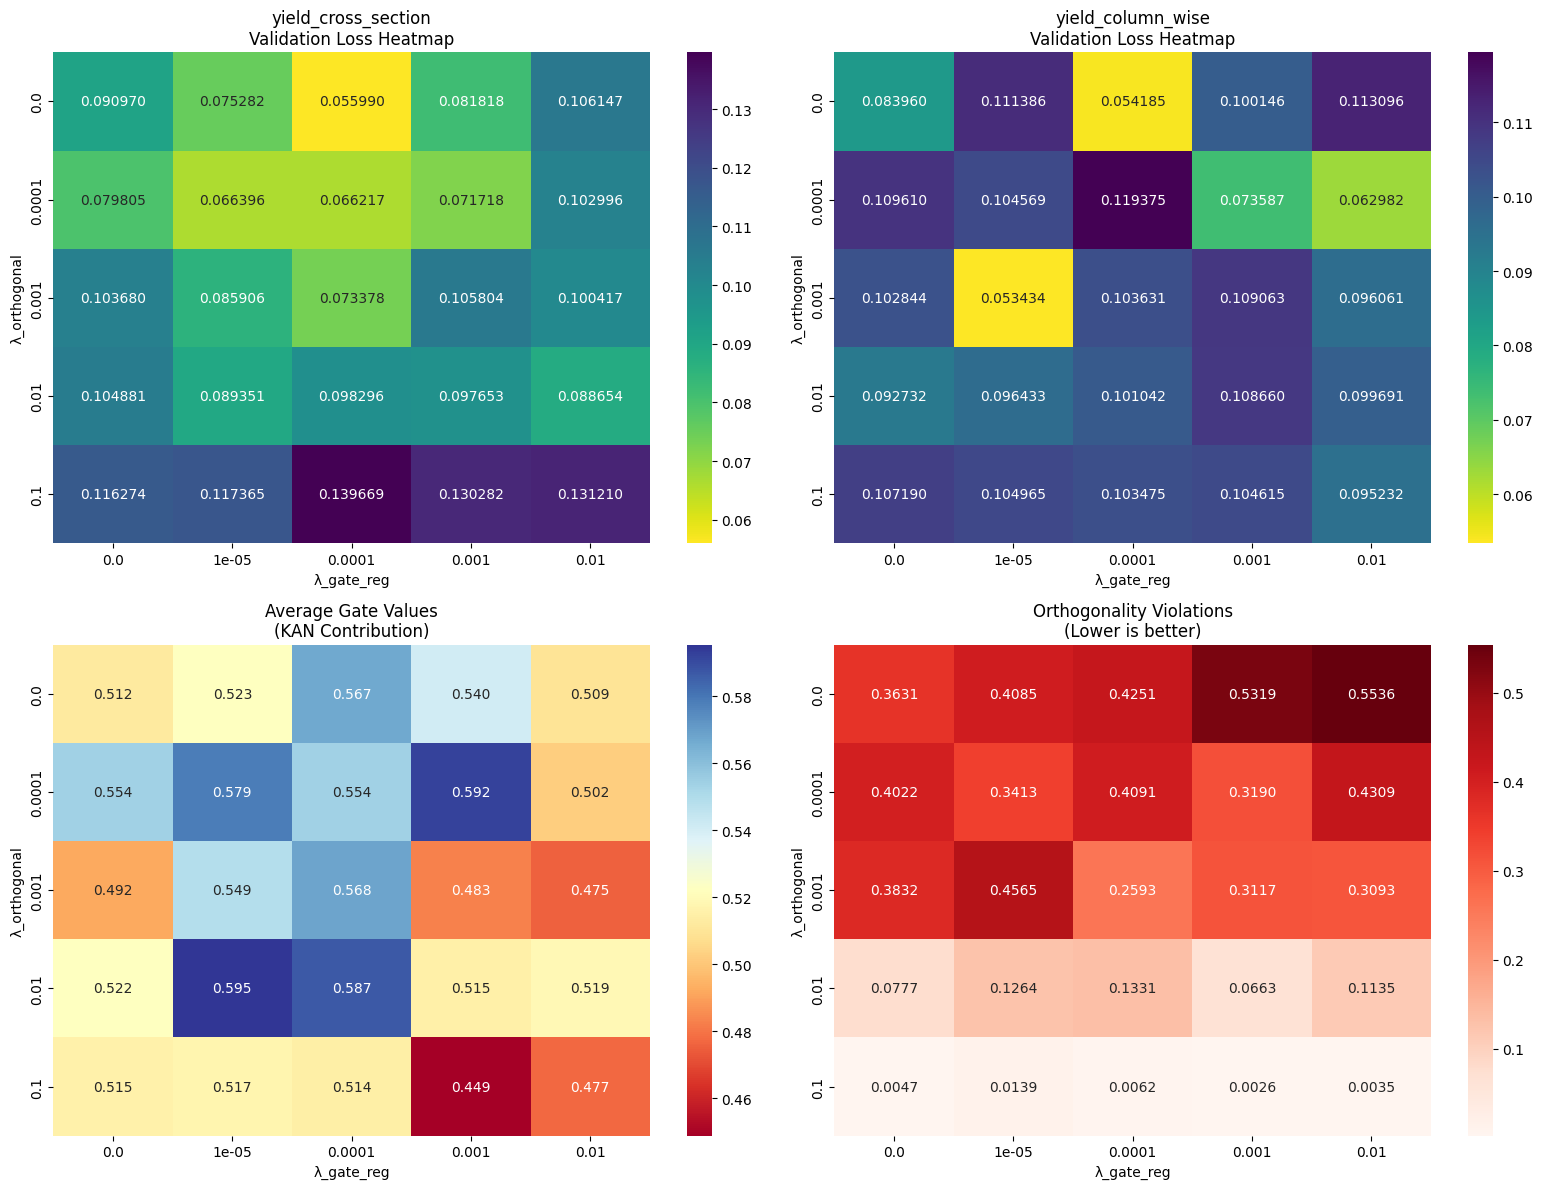


📈 STATISTICAL SUMMARY:
�� Total experiments: 50
✅ Successful: 50 (100.0%)
�� Best score: 0.053434
📈 Worst score: 0.139669
🎛️  Gate range: [0.411, 0.752]
🔀 Orth violation range: [0.0011, 0.5882]


In [13]:
# Correction de l'erreur et ajout de visualisation des courbes d'entraînement

if successful_results:
    # Préparation des données pour visualisation
    viz_data = []
    for result in successful_results:
        viz_data.append({
            'dataset': result['dataset'],
            'lambda_gate_reg': result['model_config']['lambda_gate_reg'],
            'lambda_orthogonal': result['model_config']['lambda_orthogonal'],
            'score': result['mean_score'],
            'gate_value': np.mean(result['final_gate_values']),
            'orth_violation': np.mean(result['orthogonality_violations'])
        })
    
    df_viz = pd.DataFrame(viz_data)
    
    # Heatmap des scores
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for i, dataset_name in enumerate(datasets.keys()):
        ax = axes[i//2, i%2]
        
        dataset_df = df_viz[df_viz['dataset'] == dataset_name]
        if not dataset_df.empty:
            # Pivot pour heatmap
            pivot = dataset_df.pivot_table(
                values='score', 
                index='lambda_orthogonal', 
                columns='lambda_gate_reg', 
                aggfunc='mean'
            )
            
            sns.heatmap(pivot, annot=True, fmt='.6f', cmap='viridis_r', ax=ax)
            ax.set_title(f'{dataset_name}\nValidation Loss Heatmap')
            ax.set_xlabel('λ_gate_reg')
            ax.set_ylabel('λ_orthogonal')
    
    # Heatmap des gate values (CORRECTION: utiliser 'gate_value' au lieu de 'final_gate_values')
    ax = axes[1, 0]
    pivot_gate = df_viz.pivot_table(
        values='gate_value',  # CORRECTION ICI
        index='lambda_orthogonal', 
        columns='lambda_gate_reg', 
        aggfunc='mean'
    )
    sns.heatmap(pivot_gate, annot=True, fmt='.3f', cmap='RdYlBu', ax=ax)
    ax.set_title('Average Gate Values\n(KAN Contribution)')
    ax.set_xlabel('λ_gate_reg')
    ax.set_ylabel('λ_orthogonal')
    
    # Heatmap des violations d'orthogonalité (CORRECTION: utiliser 'orth_violation' au lieu de 'orthogonality_violations')
    ax = axes[1, 1]
    pivot_orth = df_viz.pivot_table(
        values='orth_violation',  # CORRECTION ICI
        index='lambda_orthogonal', 
        columns='lambda_gate_reg', 
        aggfunc='mean'
    )
    sns.heatmap(pivot_orth, annot=True, fmt='.4f', cmap='Reds', ax=ax)
    ax.set_title('Orthogonality Violations\n(Lower is better)')
    ax.set_xlabel('λ_gate_reg')
    ax.set_ylabel('λ_orthogonal')
    
    plt.tight_layout()
    
    # Sauvegarde
    viz_file = results_dir / 'hyperparams_heatmaps.png'
    plt.savefig(viz_file, dpi=300, bbox_inches='tight')
    print(f"�� Heatmaps saved to: {viz_file}")
    
    plt.show()
    
    # Résumé statistique
    print("\n📈 STATISTICAL SUMMARY:")
    print("="*50)
    print(f"�� Total experiments: {len(all_results)}")
    print(f"✅ Successful: {len(successful_results)} ({len(successful_results)/len(all_results)*100:.1f}%)")
    print(f"�� Best score: {min(r['mean_score'] for r in successful_results):.6f}")
    print(f"📈 Worst score: {max(r['mean_score'] for r in successful_results):.6f}")
    print(f"🎛️  Gate range: [{min(np.mean(r['final_gate_values']) for r in successful_results):.3f}, {max(np.mean(r['final_gate_values']) for r in successful_results):.3f}]")
    print(f"🔀 Orth violation range: [{min(np.mean(r['orthogonality_violations']) for r in successful_results):.4f}, {max(np.mean(r['orthogonality_violations']) for r in successful_results):.4f}]")

🎯 Entraînement du meilleur modèle pour yield_cross_section...
🕒 Utilisation d'ensembles train/val séparés
   📊 Train: 7442 échantillons
   📊 Val: 1861 échantillons
⚠️  Loss pondérée demandée mais W_train/M_train manquants -> fallback loss standard
📈 Epoch 1/100 | Train: 0.331996 | Val: 0.297833 ❌
   ↳ Recon: 0.331579 | Reg: 0.000417 | Orth: 0.078575 ⚠️
   🎛️  Gate: 0.176 (KAN: 17.6%, Skip: 82.4%) | Orth_viol: 0.2306
📈 Epoch 2/100 | Train: 0.207706 | Val: 0.235244 ✅
   ↳ Recon: 0.207504 | Reg: 0.000202 | Orth: 0.462416 ⚠️
   🎛️  Gate: 0.164 (KAN: 16.4%, Skip: 83.6%) | Orth_viol: 0.6728
📈 Epoch 3/100 | Train: 0.140759 | Val: 0.205088 ✅
   ↳ Recon: 0.140503 | Reg: 0.000256 | Orth: 0.572769 ⚠️
   🎛️  Gate: 0.147 (KAN: 14.7%, Skip: 85.3%) | Orth_viol: 0.7535
📈 Epoch 4/100 | Train: 0.096959 | Val: 0.182191 ✅
   ↳ Recon: 0.096660 | Reg: 0.000299 | Orth: 0.539790 ⚠️
   🎛️  Gate: 0.135 (KAN: 13.5%, Skip: 86.5%) | Orth_viol: 0.7317
📈 Epoch 5/100 | Train: 0.070230 | Val: 0.164863 ✅
   ↳ Recon: 0.

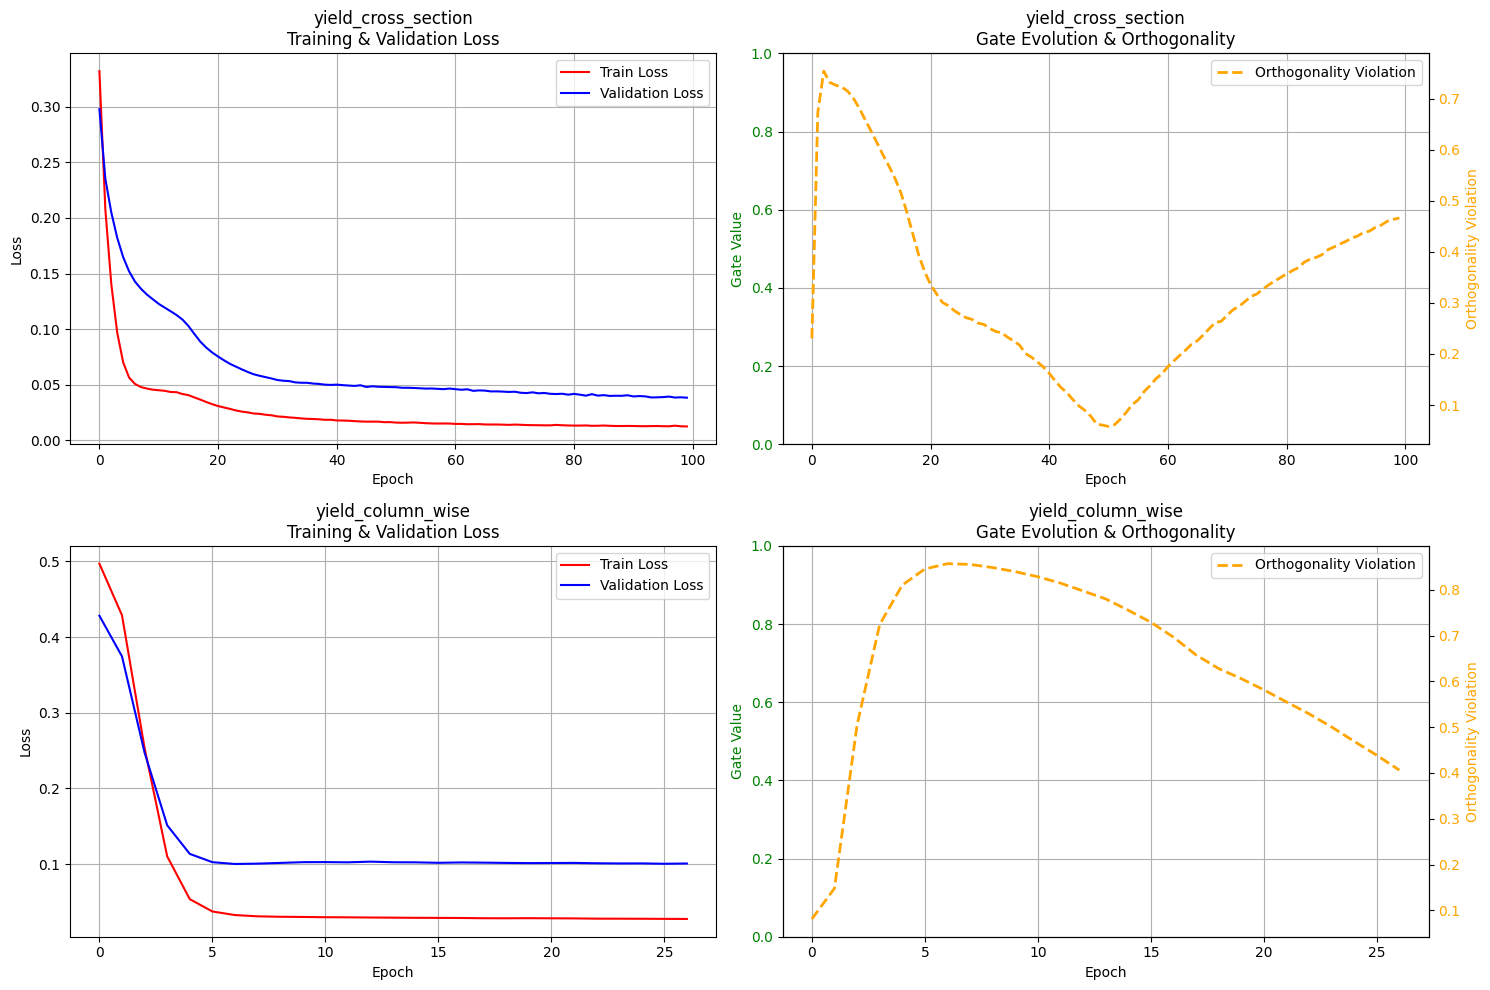

In [14]:
# Visualisation des courbes d'entraînement des meilleurs modèles

def plot_training_curves_for_best_models():
    """Visualise les courbes d'entraînement des meilleurs modèles par dataset"""
    
    if not successful_results:
        print("❌ Aucun résultat réussi à visualiser")
        return
    
    # Sélectionner les meilleurs modèles par dataset
    best_models = {}
    for dataset_name in datasets.keys():
        dataset_results = [r for r in successful_results if r['dataset'] == dataset_name]
        if dataset_results:
            best_models[dataset_name] = min(dataset_results, key=lambda x: x['mean_score'])
    
    if not best_models:
        print("❌ Aucun meilleur modèle trouvé")
        return
    
    # Créer les graphiques pour chaque meilleur modèle
    fig, axes = plt.subplots(len(best_models), 2, figsize=(15, 5*len(best_models)))
    if len(best_models) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (dataset_name, best_result) in enumerate(best_models.items()):
        print(f"🎯 Entraînement du meilleur modèle pour {dataset_name}...")
        
        # Configuration du meilleur modèle
        model_config = best_result['model_config'].copy()
        model_config['input_dim'] = datasets[dataset_name]['X'].shape[1]
        model_config['skip_rank'] = min(datasets[dataset_name]['X'].shape[1] // 4, 32)
        
        # Entraînement avec verbose pour récupérer l'historique
        X = datasets[dataset_name]['X']
        train_size = int(0.8 * len(X))
        X_train, X_val = X[:train_size], X[train_size:]
        
        model = GatedKANAutoencoder(**model_config)
        model.to(device)
        
        # Entraînement avec verbose
        training_config = TRAINING_PARAMS.copy()
        training_config['verbose'] = True
        training_config['epochs'] = 100  # Réduit pour visualisation
        
        history = model.fit(
            X_train=X_train,
            X_val=X_val,
            **training_config
        )
        
        # Graphique 1: Loss curves
        ax1 = axes[idx, 0]
        ax1.plot(history['train_loss'], label='Train Loss', color='red')
        ax1.plot(history['val_loss'], label='Validation Loss', color='blue')
        ax1.set_title(f'{dataset_name}\nTraining & Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Graphique 2: Gate evolution et autres métriques
        ax2 = axes[idx, 1]
        
        # Gate evolution
        if 'gate_evolution' in history:
            ax2.plot(history['gate_evolution'], label='Gate Value', color='green', linewidth=2)
        
        # Orthogonality violation
        if 'orthogonality_violation' in history:
            ax2_twin = ax2.twinx()
            ax2_twin.plot(history['orthogonality_violation'], label='Orthogonality Violation', 
                         color='orange', linestyle='--', linewidth=2)
            ax2_twin.set_ylabel('Orthogonality Violation', color='orange')
            ax2_twin.tick_params(axis='y', labelcolor='orange')
        
        ax2.set_title(f'{dataset_name}\nGate Evolution & Orthogonality')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Gate Value', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.grid(True)
        
        # Ajouter les légendes
        lines1, labels1 = ax2.get_legend_handles_labels()
        if 'orthogonality_violation' in history:
            lines2, labels2 = ax2_twin.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        else:
            ax2.legend(lines1, labels1)
        
        # Informations sur le modèle
        gate_info = model.get_gate_info()
        print(f"   ��️  Final gate value: {gate_info['kan_contribution']:.3f}")
        print(f"   🔀 Final orthogonality violation: {history['orthogonality_violation'][-1]:.4f}")
        print(f"   📊 Final validation loss: {history['val_loss'][-1]:.6f}")
        
        # Nettoyage
        del model
        torch.cuda.empty_cache()
    
    plt.tight_layout()
    
    # Sauvegarde
    training_curves_file = results_dir / 'best_models_training_curves.png'
    plt.savefig(training_curves_file, dpi=300, bbox_inches='tight')
    print(f"📈 Training curves saved to: {training_curves_file}")
    
    plt.show()

# Exécuter la visualisation
plot_training_curves_for_best_models()

📊 Regularization analysis saved to: results\gated_kan_hyperparams_20250903_052323\regularization_analysis.png


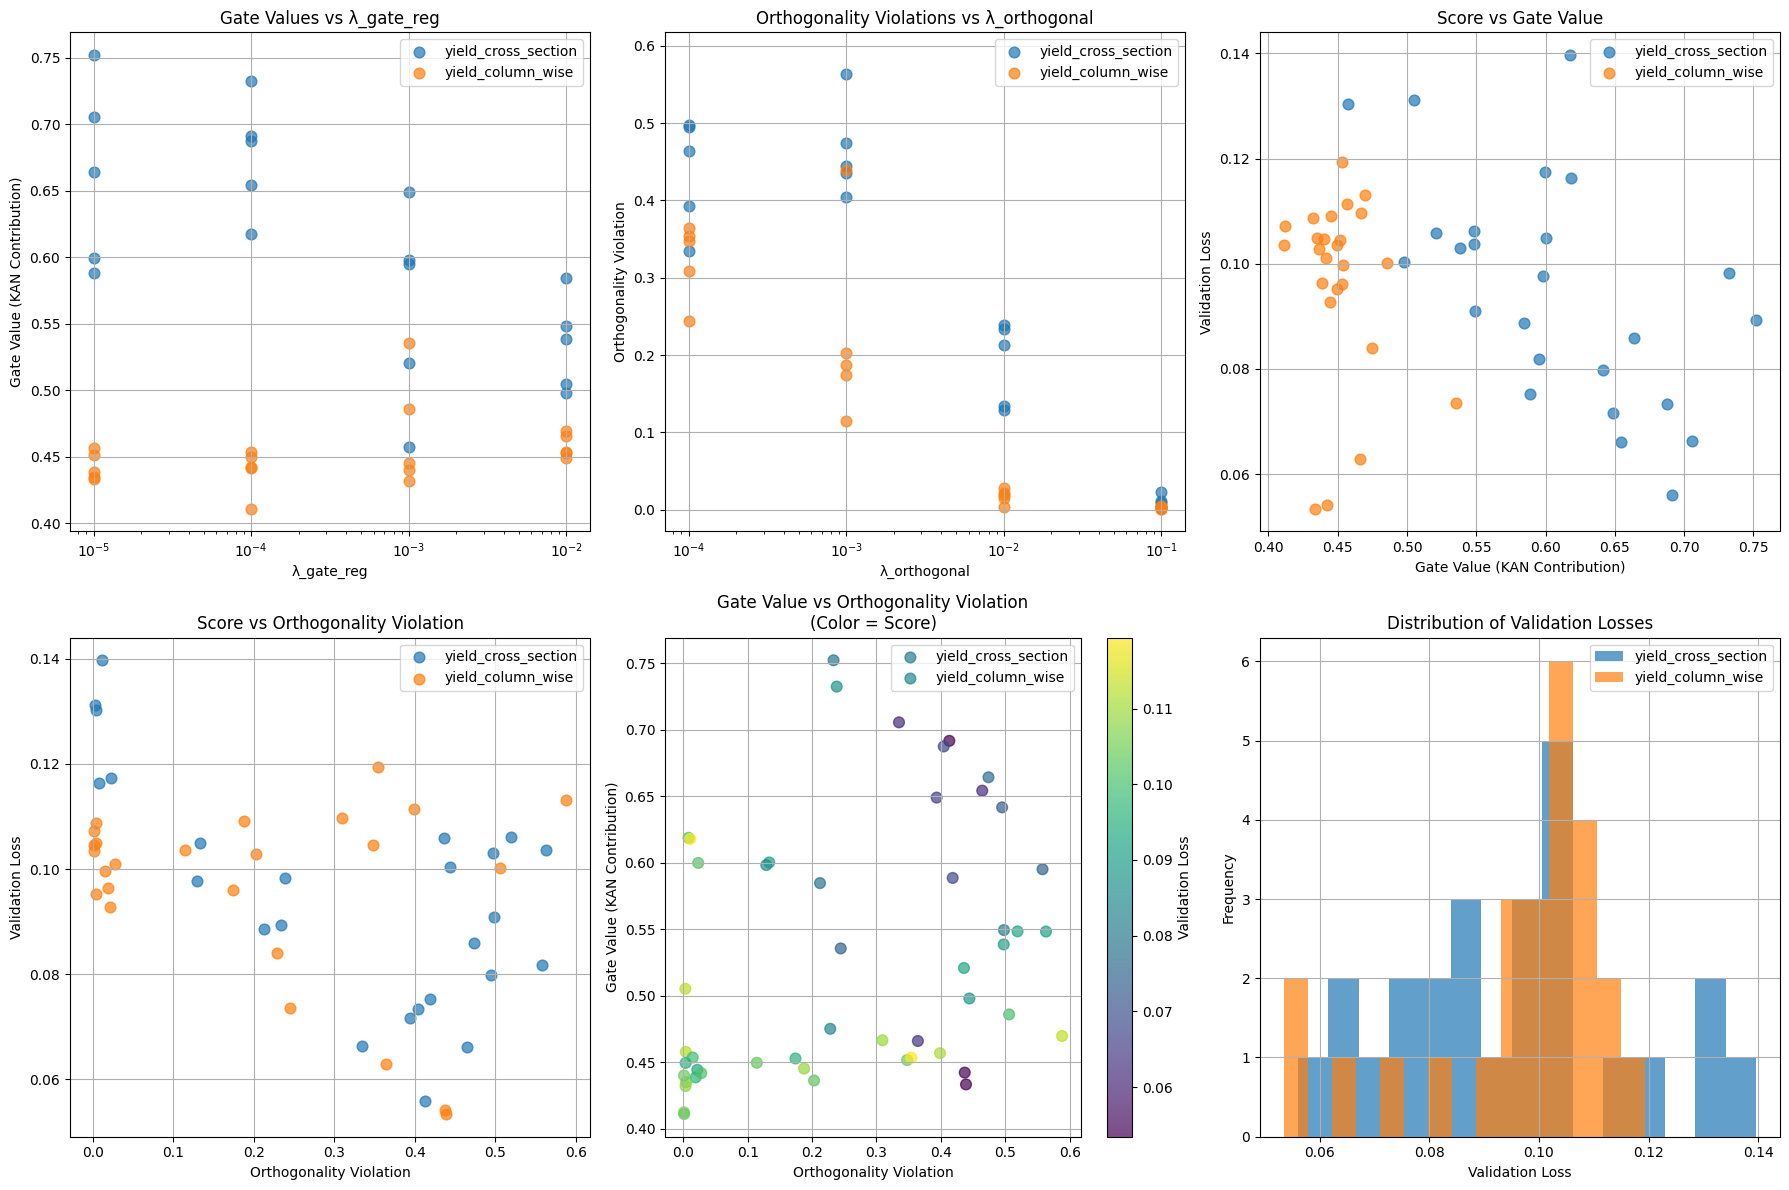

In [15]:
# Visualisation détaillée des métriques de régularisation

def plot_regularization_analysis():
    """Analyse détaillée des métriques de régularisation"""
    
    if not successful_results:
        print("❌ Aucun résultat réussi à analyser")
        return
    
    # Préparer les données
    reg_data = []
    for result in successful_results:
        reg_data.append({
            'dataset': result['dataset'],
            'lambda_gate_reg': result['model_config']['lambda_gate_reg'],
            'lambda_orthogonal': result['model_config']['lambda_orthogonal'],
            'gate_value': np.mean(result['final_gate_values']),
            'orth_violation': np.mean(result['orthogonality_violations']),
            'score': result['mean_score']
        })
    
    df_reg = pd.DataFrame(reg_data)
    
    # Créer les graphiques
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Gate values vs lambda_gate_reg
    ax = axes[0, 0]
    for dataset_name in datasets.keys():
        dataset_df = df_reg[df_reg['dataset'] == dataset_name]
        if not dataset_df.empty:
            ax.scatter(dataset_df['lambda_gate_reg'], dataset_df['gate_value'], 
                      label=dataset_name, alpha=0.7, s=60)
    ax.set_xlabel('λ_gate_reg')
    ax.set_ylabel('Gate Value (KAN Contribution)')
    ax.set_xscale('log')
    ax.set_title('Gate Values vs λ_gate_reg')
    ax.legend()
    ax.grid(True)
    
    # 2. Orthogonality violations vs lambda_orthogonal
    ax = axes[0, 1]
    for dataset_name in datasets.keys():
        dataset_df = df_reg[df_reg['dataset'] == dataset_name]
        if not dataset_df.empty:
            ax.scatter(dataset_df['lambda_orthogonal'], dataset_df['orth_violation'], 
                      label=dataset_name, alpha=0.7, s=60)
    ax.set_xlabel('λ_orthogonal')
    ax.set_ylabel('Orthogonality Violation')
    ax.set_xscale('log')
    ax.set_title('Orthogonality Violations vs λ_orthogonal')
    ax.legend()
    ax.grid(True)
    
    # 3. Score vs Gate Value
    ax = axes[0, 2]
    for dataset_name in datasets.keys():
        dataset_df = df_reg[df_reg['dataset'] == dataset_name]
        if not dataset_df.empty:
            ax.scatter(dataset_df['gate_value'], dataset_df['score'], 
                      label=dataset_name, alpha=0.7, s=60)
    ax.set_xlabel('Gate Value (KAN Contribution)')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Score vs Gate Value')
    ax.legend()
    ax.grid(True)
    
    # 4. Score vs Orthogonality Violation
    ax = axes[1, 0]
    for dataset_name in datasets.keys():
        dataset_df = df_reg[df_reg['dataset'] == dataset_name]
        if not dataset_df.empty:
            ax.scatter(dataset_df['orth_violation'], dataset_df['score'], 
                      label=dataset_name, alpha=0.7, s=60)
    ax.set_xlabel('Orthogonality Violation')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Score vs Orthogonality Violation')
    ax.legend()
    ax.grid(True)
    
    # 5. Gate Value vs Orthogonality Violation
    ax = axes[1, 1]
    for dataset_name in datasets.keys():
        dataset_df = df_reg[df_reg['dataset'] == dataset_name]
        if not dataset_df.empty:
            scatter = ax.scatter(dataset_df['orth_violation'], dataset_df['gate_value'], 
                               c=dataset_df['score'], cmap='viridis', 
                               label=dataset_name, alpha=0.7, s=60)
    ax.set_xlabel('Orthogonality Violation')
    ax.set_ylabel('Gate Value (KAN Contribution)')
    ax.set_title('Gate Value vs Orthogonality Violation\n(Color = Score)')
    ax.legend()
    ax.grid(True)
    plt.colorbar(scatter, ax=ax, label='Validation Loss')
    
    # 6. Distribution des scores
    ax = axes[1, 2]
    for dataset_name in datasets.keys():
        dataset_df = df_reg[df_reg['dataset'] == dataset_name]
        if not dataset_df.empty:
            ax.hist(dataset_df['score'], alpha=0.7, label=dataset_name, bins=15)
    ax.set_xlabel('Validation Loss')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Validation Losses')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    
    # Sauvegarde
    reg_analysis_file = results_dir / 'regularization_analysis.png'
    plt.savefig(reg_analysis_file, dpi=300, bbox_inches='tight')
    print(f"📊 Regularization analysis saved to: {reg_analysis_file}")
    
    plt.show()

# Exécuter l'analyse de régularisation
plot_regularization_analysis()